# Thesis random sweeps - 4Try - Receptive Field width effect

4/4


In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [13]:
overwrite = False
cache_filename = ("/nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/"
                  "fisher2016_random_rcscale_4try_repetitions5_160417/outputs/df_out.pkl")

if os.path.exists(cache_filename) and not overwrite:
    import reloader_fisher2016_random_rcscale_4try_160417 as rel
    generator_module = rel.generator_module
    dataset_infos = rel.dataset_infos
    df_all_fits = pd.read_pickle(cache_filename)
else:
    with io.capture_output(display=False, stdout=True) as captured:
        %run reloader_fisher2016_random_rcscale_4try_160417.py

In [14]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fisherinfo_new_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_rcscale_4try_repetitions5_160417/outputs/thesis_rcwidtheffect_rnd-<module>-e6a87231-f51b-454c-846a-cc53657a61f1 ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_rcscale_4try_repetitions5_160417/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_rcscale_4try_repetitions5_160417_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_rcscale_4try_repetitions5_160417/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_rcscale_4try_repetitions5_160417_outputs


In [15]:
def avg_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(array, axis=-1))]
def avg_twice_lastaxis(array_name, array):
    return [(array_name, utils.nanmean(utils.nanmean(array, axis=-1), axis=-1))]
def std_lastaxis(array_name, array):
    return [('std_' + array_name, utils.nanstd(array, axis=-1))]


def process_precision(array_name, array):
    outputs = avg_lastaxis(array_name, array)
    outputs.extend(std_lastaxis(array_name, array))
    outputs.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs
    
def process_fi(array_name, array):
    outputs = avg_twice_lastaxis(array_name, array)
    outputs.extend(avg_twice_lastaxis(array_name + "_stddev", (2./array)**0.5))
    return outputs

def process_marginal_fi(array_name, array):
    # Marginal FI/Inv FI have (mean, std), just keep mean
    outputs_all = avg_lastaxis(array_name, array)
    
    if array_name.find('inv') > -1:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2.*array)**0.5))
    else:
        outputs_all.extend(avg_lastaxis(array_name + "_stddev", (2./array)**0.5))
    
    outputs = [(o[0], o[1][:, 0]) for o in outputs_all]
    return outputs

def process_em_fits(array_name, array):
    emfits_all = utils.nanmean(array, axis=-1)
    outputs = [(array_name + "_" + colname, emfits_all[:, col_i])
            for col_i, colname in enumerate(['kappa',
                                             'target',
                                             'nontargets',
                                             'random',
                                             'LL',
                                             'bic'])
              ]
    outputs.append((array_name + '_fidelity', 1./utils.kappa_to_stddev(emfits_all[:, 0])**2.))
    outputs.append((array_name + '_stddev', utils.kappa_to_stddev(emfits_all[:, 0])))
    
    return outputs

    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [16]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

In [17]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [18]:
# Extract data
if not os.path.exists(cache_filename) or overwrite:
    num_repetitions = generator_module.num_repetitions
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    all_args_arr = np.array(data_pbs.loaded_data['args_list'])

    pandas_columns_with_processing = [
        ('result_all_precisions', dict(name='precision', process=process_precision)),
        ('result_FI_rc_curv', dict(name='fi_curv', process=process_fi)),
        ('result_FI_rc_theo', dict(name='fi_theo', process=process_fi)),
        ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=process_fi)),
        ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
        ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
        ('result_em_fits', dict(name='emfit', process=process_em_fits)),
    ]

    df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
    df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

    df_all_fits.to_pickle(cache_filename)
else:
    df_all_fits = pd.read_pickle(cache_filename)

In [19]:
df_all_fits.loc[:, ('fi_fidelity_ratio')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
df_all_fits.loc[:, ('fi_stddev_ratio')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
df_all_fits.loc[:, ('margfi_stddev_ratio')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

df_all_fits = df_all_fits[df_all_fits['inv_fi_marginal_stddev'] < 1.5*np.pi]

M_space = np.sort(df_all_fits['M'].unique())
rc_scale_space = np.sort(df_all_fits['rc_scale'].unique())

In [20]:
df_all_fits.describe()

,precision,std_precision,precision_stddev,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,M,rc_scale,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,...,9.428000e+03,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000,9428.000000
mean,67.781932,11.456174,0.423233,208.258421,0.129295,195.529667,0.156383,195.529667,0.156383,188.447276,...,6.947310e-02,89.332641,-162.770329,88.632149,0.135481,315.382160,14.668268,1.178462,1.092106,1.369787
std,58.529086,12.754121,0.472461,104.955360,0.095353,103.576018,0.173454,103.576018,0.173454,116.831561,...,1.444747e-01,149.603703,299.207406,59.015768,0.083871,163.786394,8.703827,0.221349,1.932289,2.545309
min,0.204799,0.014407,0.099759,0.434001,0.073649,0.114940,0.073534,0.114940,0.073534,0.091594,...,3.083184e-10,-365.929291,-477.239799,0.578714,0.018575,9.000000,0.007606,0.000031,0.854795,0.650723
25%,8.523772,1.666655,0.132612,120.259314,0.085249,107.020567,0.084624,107.020567,0.084624,86.571320,...,4.727282e-09,26.725687,-384.927199,41.607994,0.086773,169.000000,7.009483,1.039561,0.948180,0.924335
50%,57.926455,7.769160,0.196373,211.026459,0.100623,199.670161,0.103212,199.670161,0.103212,198.886649,...,3.609726e-03,148.707500,-281.520048,87.554486,0.106871,324.000000,14.511800,1.110327,0.974138,0.981879
75%,118.786245,15.604734,0.500741,296.998488,0.136723,280.646962,0.150818,280.646962,0.150818,286.266222,...,5.045892e-02,200.411075,-37.556422,132.811015,0.155029,441.000000,22.104060,1.246097,1.003773,1.032600
max,202.610345,75.552871,3.154073,397.405783,2.465715,371.964015,4.171368,371.964015,4.171368,414.415756,...,9.180075e-01,246.567375,747.753534,2898.330640,1.314523,576.000000,29.998901,2.562475,179.954626,179.954626


In [21]:
# Remove outliers
df_fits_filtered = remove_outliers(df_all_fits, 10)

In [22]:
df_fits_filtered.describe()

,precision,std_precision,precision_stddev,fi_curv,fi_curv_stddev,fi_theo,fi_theo_stddev,fi_theo_cov,fi_theo_cov_stddev,fi_marginal,...,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,M,rc_scale,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,...,9.378000e+03,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000,9378.000000
mean,68.140466,11.516912,0.414519,209.219066,0.126166,196.443631,0.150580,196.443631,0.150580,189.449965,...,6.714651e-02,91.490085,-167.085218,88.710066,0.133932,316.633291,14.679506,1.179872,1.055652,1.287032
std,58.478018,12.760850,0.457269,104.392834,0.073331,103.080342,0.139402,103.080342,0.139402,116.330558,...,1.404780e-01,147.027119,294.054238,51.291901,0.076690,163.220520,8.696651,0.218336,0.395792,1.427143
min,0.315182,0.014407,0.099759,3.007138,0.073649,2.325870,0.073534,2.325870,0.073534,0.136348,...,3.083184e-10,-348.715030,-477.239799,1.059005,0.070254,9.000000,0.026677,0.387648,0.854795,0.650723
25%,8.955938,1.764766,0.132464,122.981593,0.085199,107.579982,0.084607,107.579982,0.084607,87.729016,...,4.608178e-09,29.553400,-385.135893,42.006604,0.086710,169.000000,7.020433,1.040289,0.948003,0.923583
50%,58.561749,7.838003,0.195428,212.208265,0.100509,201.912187,0.102554,201.912187,0.102554,200.446921,...,3.527664e-03,149.204600,-282.514249,88.080038,0.106552,324.000000,14.516913,1.110403,0.973878,0.981511
75%,119.201037,15.682541,0.489715,297.398041,0.135498,280.772884,0.149942,280.772884,0.149942,287.308332,...,4.740605e-02,200.515423,-43.211847,133.003389,0.154291,441.000000,22.115704,1.246030,1.003068,1.030569
max,202.610345,75.552871,2.544910,397.405783,0.894412,371.964015,1.778565,371.964015,1.778565,414.415756,...,8.068371e-01,246.567375,713.325012,202.610354,0.971742,576.000000,29.998901,2.562475,6.948504,21.371603


## Quantize parameters

In [40]:
nQuantiles = 31
parameters = ['rc_scale']

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)

df_quantized.loc[:, 'fi_marginal_half'] = df_quantized['fi_marginal']/2
df_quantized.loc[:, 'fi_theo_half'] = df_quantized['fi_theo']/2

## 2D plot M/rc_scale

In [41]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None, ax=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    
    return utils.plot_mean_std_area(df_mean[x_col], #param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel,
                                    ax_handle=ax,
                                    label=y_col
                                   )

In [42]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if "std_" + interpolate_column in df:
        w = 1./df["std_" + interpolate_column]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', 
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    x_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [43]:
df_avg = df_quantized.groupby(('M', 'rc_scale')).mean().reset_index()
df_avg['precision_norm'] = (df_avg['precision'] - df_avg.groupby('M')['precision'].transform(np.nanmin)
                           )/df_avg.groupby('M')['precision'].transform(np.nanmax)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f61fafddb50>,
 <matplotlib.image.AxesImage at 0x7f61fafabfd0>)

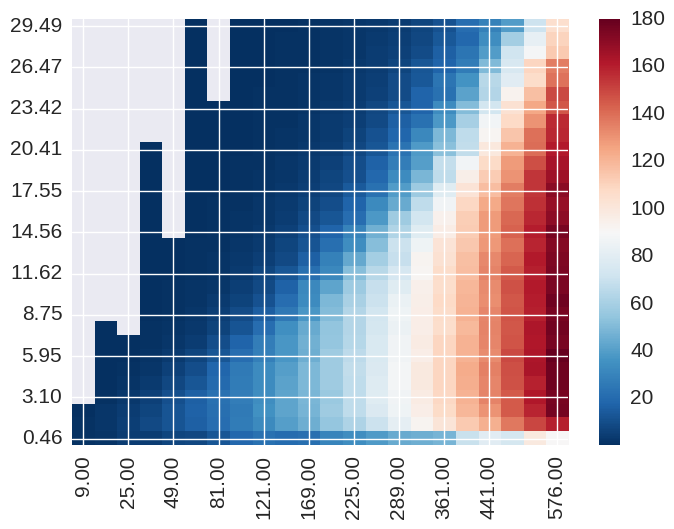

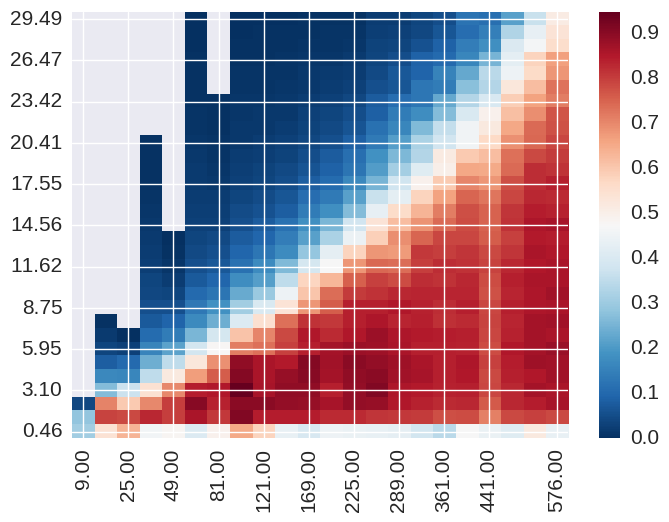

In [44]:
data_M_rcscale = df_avg.pivot_table(index='M', columns='rc_scale_qi', values='precision').as_matrix()
utils.pcolor_2d_data(data_M_rcscale, x=M_space, y=param_qbins_middle['rc_scale'], 
                     ticks_interpolate=11, cmap='RdBu_r')

data_M_rcscale_2 = df_avg.pivot_table(index='M', columns='rc_scale_qi', values='precision_norm').as_matrix()
utils.pcolor_2d_data(data_M_rcscale_2, x=M_space, y=param_qbins_middle['rc_scale'], 
                     ticks_interpolate=11, cmap='RdBu_r')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f61fae054d0>,
 <matplotlib.image.AxesImage at 0x7f61facbfd90>)

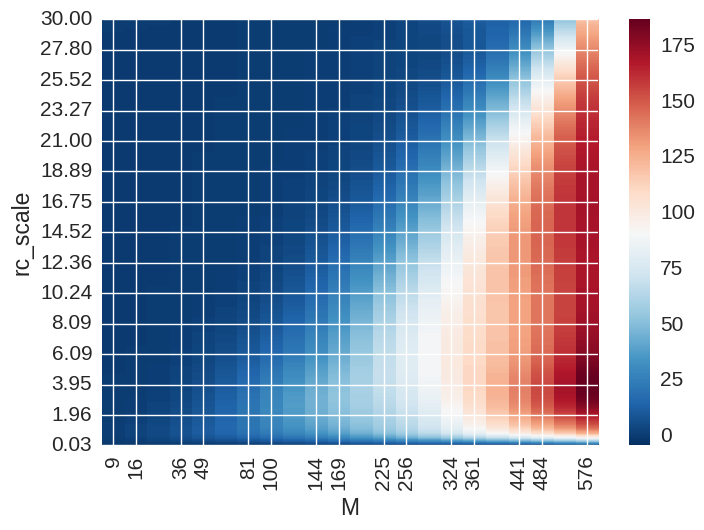

In [45]:
pcolor_2d_interpolated(df_avg, 'precision', y_col='rc_scale')

In [46]:
def plot_receptive_field_target_M(df, M_target=196):
    df_specific_M = df[df.M == M_target]

    ax = plot_mean_std_df(df_specific_M, 'rc_scale', 'precision', param_qbins_middle)
    ax = plot_mean_std_df(df_specific_M, 'rc_scale', 'emfit_fidelity', param_qbins_middle, ax=ax)
    ax = plot_mean_std_df(df_specific_M, 'rc_scale', 'fi_theo_half', param_qbins_middle, ax=ax)
    ax.set_xlabel("Receptive field width")
    ax.set_title("M: {}".format(M_target))
    plt.legend(loc='best')

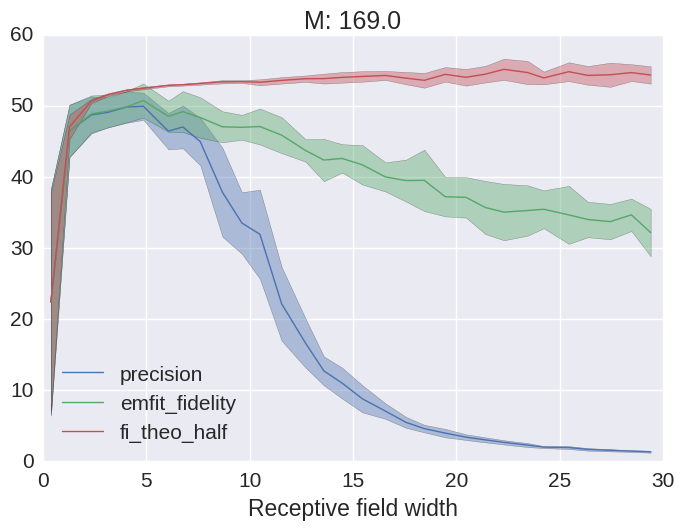

In [64]:
plot_receptive_field_target_M(df_avg, M_target=13**2.)

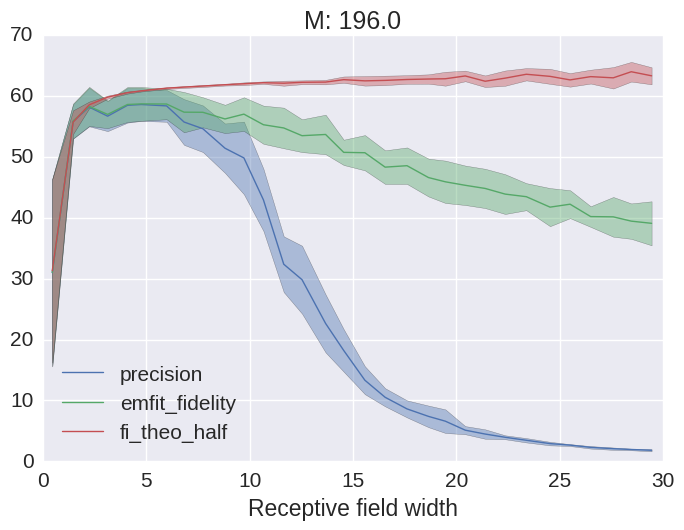

In [65]:
plot_receptive_field_target_M(df_avg, M_target=14**2.)

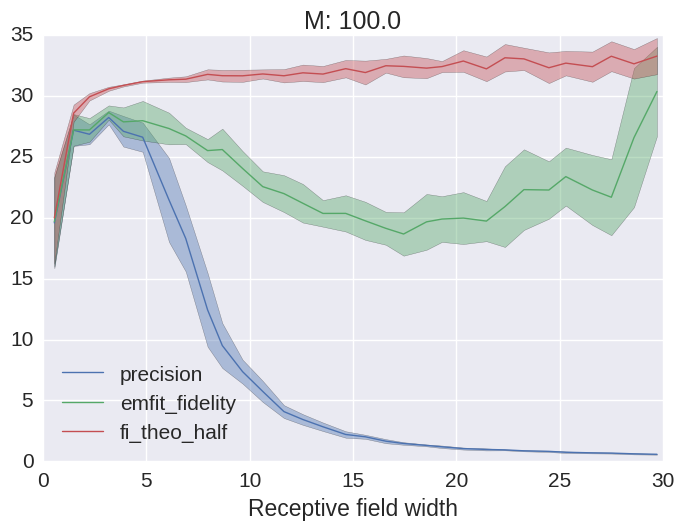

In [50]:
plot_receptive_field_target_M(df_avg, M_target=10**2.)